In [29]:
import becquerel as bq
import pandas as pd
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math as m

In [30]:
def gaussian(x):
    return (spec.livetime * amp /(m.sqrt(2*m.pi)*sigma)) * m.exp(- ((x-mu)**2) / (2*sigma**2))

In [31]:
spectrum = r'C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Samples 2017\UCB087_Wild_King_Salmon_3.Spe'
background = r'C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Samples 2017\UCB096_Backgorund_2_13_17.Spe'

spec = Spectrum.from_file(spectrum) #import spectrum from file
len(spec)
bg = Spectrum.from_file(background)

SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Samples 2017\UCB087_Wild_King_Salmon_3.Spe
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Samples 2017\UCB096_Backgorund_2_13_17.Spe


In [32]:
#test spectrum functions
print(spec.start_time)
print(spec.stop_time)
print(spec.realtime)
print(spec.livetime)

2017-01-27 17:40:13
2017-01-30 05:41:06
216053.0
216000.0


In [33]:
#input of sources
#energy and activities

#22 sources from Tyler's efficiency csv
#source_energy = np.array([661.657,59.54,238.6,583.2,2614.5,80.8983,276.38,302.85,356.017,383.851,121.7817,244.6975,
#344.2785,411.1163,778.904,867.373,964.079,1085.869,1112.069,1212.948,1299.14,1408.006]);
#22 activity placeholders
#source_activity = np.linspace(1,22,22);

#specific for this spectrum
#https://drive.google.com/drive/u/0/folders/0BwU6Sr8Jh6Sgd2dabnZ6N1ZxMEk
# K-40, Bi-214, Tl-208
# indices 8140, 9835, 14574
source_energy = np.array([1460, 609, 2614]);
source_activity = np.array([1, 2, 3]);

In [13]:
counts = spec.counts_vals
energies = spec.bin_centers_kev

#function to find index of closest energy where a is the desired energy and n is 
def f_near(a,a0):
    idx = np.abs(a - a0).argmin()
    return idx

In [14]:
bgspec = np.subtract(spec, bg)

C:\Users\ahanks\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)


0.011909722222222226

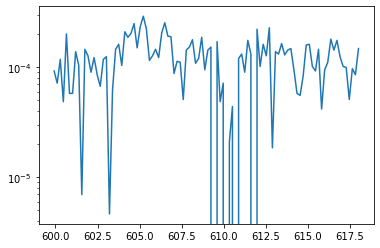

In [15]:
#test plotting
iso_idx = f_near(energies,source_energy[1])
roi_low = iso_idx - 50
roi_high = iso_idx + 50
#plot_counts = spec.counts_vals[roi_low:roi_high]
plot_counts = bgspec.cps_vals[roi_low:roi_high]
plot_energies = spec.energies_kev[roi_low:roi_high]
plt.plot(plot_energies,plot_counts)
#plt.plot(spec.energies_kev,spec.counts_vals)
plt.yscale('log')
np.argmax(counts)
np.sum(plot_counts)

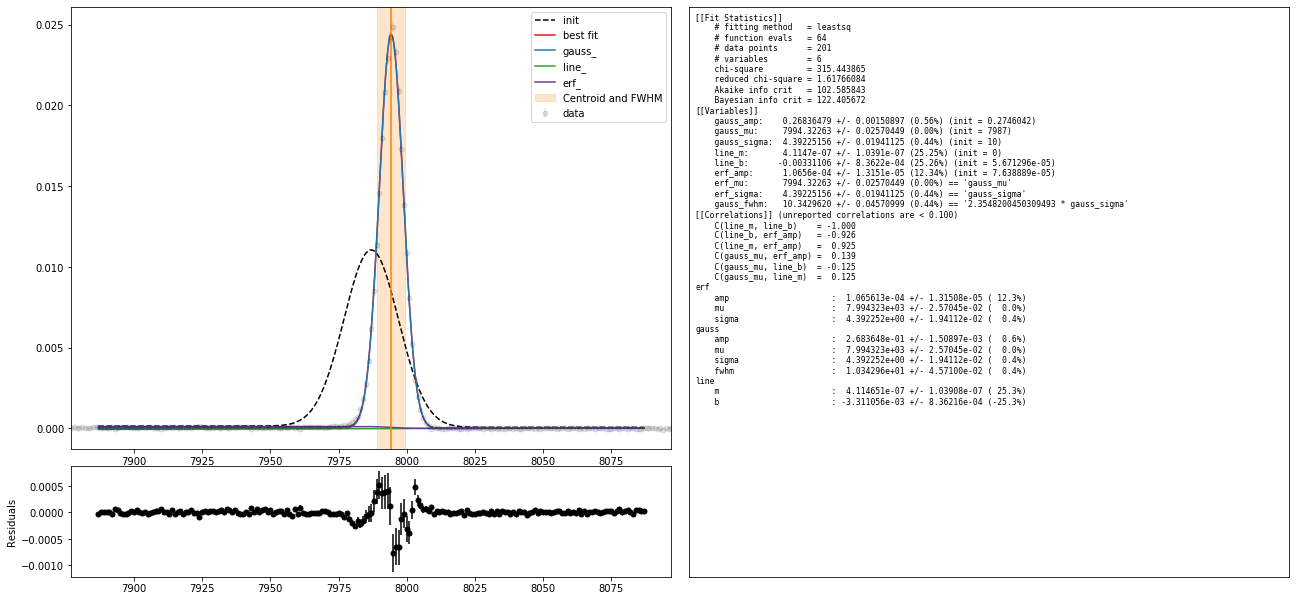

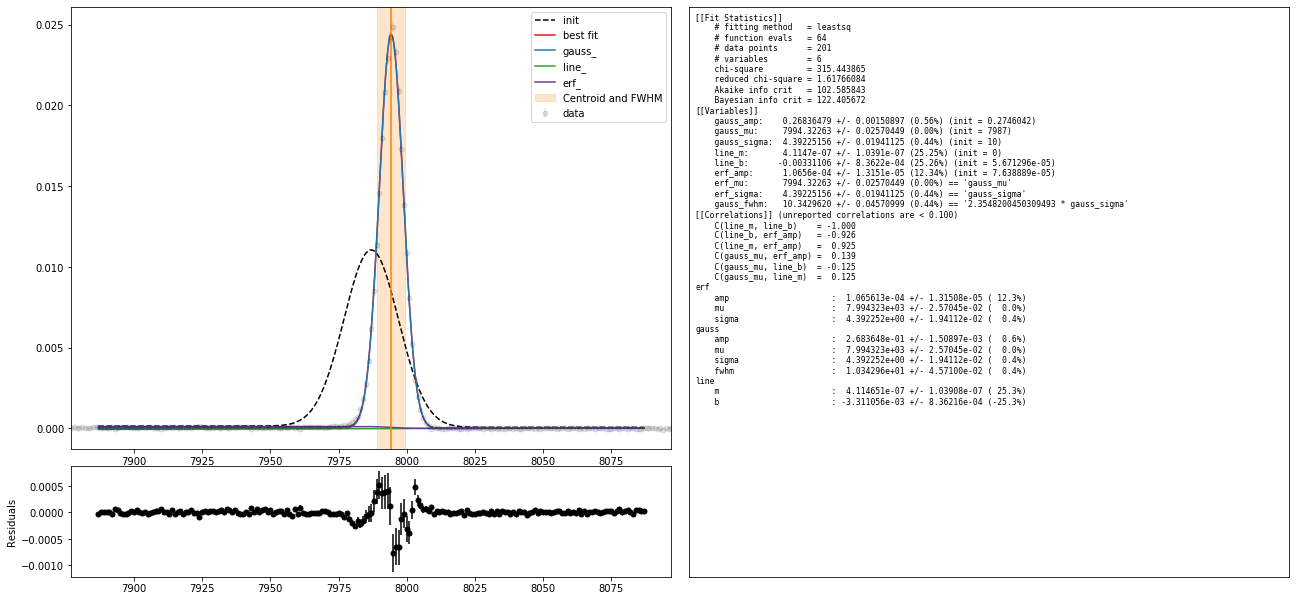

In [17]:
model = ['gauss','line','erf']
fit = bq.core.fitting.Fitter(model, x=bgspec.bin_indices, y=bgspec.cps_vals, y_unc=bgspec.cps_uncs)
idx = f_near(energies,1460)
fit.set_roi(idx-100, idx+100)
fit.fit()

#fit.results.params.pretty_print()

fit.custom_plot()

In [18]:
fit.result.params.pretty_print()

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
erf_amp      0.0001066        0      inf 1.315e-05     True     None     None
erf_mu           7994     -inf      inf   0.0257    False gauss_mu     None
erf_sigma       4.392     -inf      inf  0.01941    False gauss_sigma     None
gauss_amp      0.2684        0      inf 0.001509     True     None     None
gauss_fwhm      10.34     -inf      inf  0.04571    False 2.3548200450309493 * gauss_sigma     None
gauss_mu         7994     7887     8087   0.0257     True     None     None
gauss_sigma     4.392        0      inf  0.01941     True     None     None
line_b       -0.003311     -inf      inf 0.0008362     True     None     None
line_m       4.115e-07     -inf      inf 1.039e-07     True     None     None


In [19]:
#calculate integral of fitted Gaussian
amp = fit.result.params['gauss_amp'].value
mu = fit.result.params['gauss_mu'].value
sigma =fit.result.params['gauss_sigma'].value

integral = integrate.quad(gaussian, idx-100, idx+100)
print(integral)

(57966.79400977201, 0.00056368939387841)


In [25]:
sigma_unc = fit.result.params['gauss_sigma'].stderr
print(sigma_unc)
amp_unc = fit.result.params['gauss_amp'].stderr
print(amp_unc)
amp = fit.result.params['gauss_amp'].value + amp_unc
sigma = fit.result.params['gauss_sigma'].value + sigma_unc

integral_up = integrate.quad(gaussian, idx-100, idx+100)
print(integral)

0.019411246561982034
0.0015089696733092582
(57640.8565603372, 0.0007322224263368812)


In [26]:
amp = fit.result.params['gauss_amp'].value - amp_unc
sigma = fit.result.params['gauss_sigma'].value - sigma_unc

integral_low = integrate.quad(gaussian, idx-100, idx+100)
print(integral)

(57640.8565603372, 0.0007322224263368812)


In [28]:
counts_unc = (integral_up[0] - integral_low[0])/2.0
print(counts_unc)

325.93744943480124


In [ ]:
#Now doing it iteratively through all energies
integrals = []

for n in source_energy:
    model = ['gauss','line','erf']
    fit = bq.core.fitting.Fitter(model, x=spec.bin_indices, y=spec.cps_vals, y_unc=spec.cps_uncs)
    idx = f_near(energies,n)
    print(idx)
    fit.set_roi(idx-100, idx+100)
    fit.fit()
    amp = fit.result.params['gauss_amp'].value
    mu = fit.result.params['gauss_mu'].value
    sigma = fit.result.params['gauss_sigma'].value
    integral = integrate.quad(gaussian, idx-100, idx+100)
    integrals.append(integral[0])

print(integrals)

In [ ]:
#Testing 1764
idx = f_near(energies,1764)
print(idx)
plot_counts = spec.counts_vals[idx-40:idx+40]
plot_energies = spec.energies_kev[idx-40:idx+40]
plt.plot(plot_energies,plot_counts)
plt.yscale('log')

In [ ]:
model = ['gauss','line','erf']
fit = bq.core.fitting.Fitter(model, x=spec.bin_indices, y=spec.cps_vals, y_unc=spec.cps_uncs)
idx = f_near(energies,1460)
fit.set_roi(idx-100, idx+100)
fit.fit()

amp = fit.result.params['gauss_amp'].value
mu = fit.result.params['gauss_mu'].value
sigma = fit.result.params['gauss_sigma'].value
integral = integrate.quad(gaussian, idx-100, idx+100)

print()
print(integral)
fit.custom_plot()

In [ ]:
#Testing 2614
idx = f_near(energies,2614)
print(idx)
plot_counts = spec.counts_vals[idx-40:idx+40]
plot_energies = spec.energies_kev[idx-40:idx+40]
plt.plot(plot_energies,plot_counts)
plt.yscale('log')

In [4]:
fit.set_roi(idx-40, idx+40)
fit.fit()
fit.params #type is lmfit.parameter.Parameters
fit.params.pretty_print()
fit.custom_plot()
amp = fit.result.params['gauss_amp'].value
mu = fit.result.params['gauss_mu'].value
sigma = fit.result.params['gauss_sigma'].value
integral = integrate.quad(gaussian, idx-100, idx+100)

print(integral)

NameError: name 'fit' is not defined

In [5]:
source_isotopes = np.array(['K-40','Bi-214','Tl-208']);
source_energy = np.array([1460, 1764, 2614]);
source_activity = np.array([1, 2, 3]);

efficiencies = []
for x in range(0,len(source_activity)):
    iso = bq.Isotope(source_isotopes[x])
    efficiency = integrals[x]/source_activity[x]
    efficiencies = np.append(efficiencies,efficiency)


NameError: name 'integrals' is not defined